# **Imports**

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import os
import joblib

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_dir = "../scripts/data"
model_file_name = "new_df_20251119.joblib"
path = os.path.join(data_dir, model_file_name)
new_df = joblib.load(path)

In [4]:
new_df.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'his_growth_1h',
 'his_growth_4h',
 'his_growth_8h',
 'his_growth_24h',
 'his_growth_120h',
 'his_growth_360h',
 'EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'growing_moving_average',
 'high_minus_low_relative',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative',
 'returns',
 'volatility',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv

In [5]:
new_df[(new_df["split"] == "test")&(new_df["Ticker_BTC"] == 1)].pred11_rf_best_rule_65.sum()

259

In [136]:
def plot_trades_on_candlestick(df, prediction_col, output_file="candlestick_trades.html"):
    """
    Plot candlestick chart with entry (buy) and exit (sell) markers.
    Exits are placed at the maximum Close within the next 24 periods after each entry.
    Uses df.index (hourly timestamps) instead of a 'Date' column.
    """

    # Ensure required columns exist
    required_cols = {"Open", "High", "Low", "Close"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain {required_cols}")

    # Candlestick chart
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,   # use index (hourly timestamps)
        open=df["Open"],
        high=df["High"],
        low=df["Low"],
        close=df["Close"],
        name="Candlestick"
    )])

    # Entries (where prediction == 1)
    entries = df.loc[(df["split"] == "test") & (df[prediction_col] == 1), ["Close"]]

    fig.add_trace(go.Scatter(
        x=entries.index,   # index instead of Date
        y=entries["Close"],
        mode="markers",
        marker=dict(symbol="triangle-up", size=12, color="green"),
        name="Entry"
    ))

    # Exits: maximum Close within next 24 periods after each entry
    exit_times = []
    exit_prices = []

    for entry_time in entries.index:
        lookahead = df.loc[(df.index > entry_time) & (df.index <= entry_time + pd.Timedelta(hours=24))]
        if lookahead.empty:
            continue
            
        # Find row with maximum Close
        max_row = lookahead.loc[lookahead["Close"].idxmax()]
        exit_times.append(max_row.name)
        exit_prices.append(max_row["Close"])

    fig.add_trace(go.Scatter(
        x=exit_times,
        y=exit_prices,
        mode="markers",
        marker=dict(symbol="triangle-down", size=12, color="red"),
        name="Exit"
    ))

    # Layout with rangeslider
    fig.update_layout(
        title=f"Trades for {prediction_col} (Exit at max Close in next 24 hours)",
        xaxis_title="Timestamp",
        yaxis_title="Price",
        xaxis=dict(
            rangeslider=dict(visible=True),  # bottom panel for zooming
            type="date"
        ),
        template="plotly_white"
    )

    fig.write_html(output_file)
    print(f"Candlestick trade chart saved to: {output_file}")
    return fig


Candlestick trade chart saved to: candlestick_trades_BTCtestOnly.html


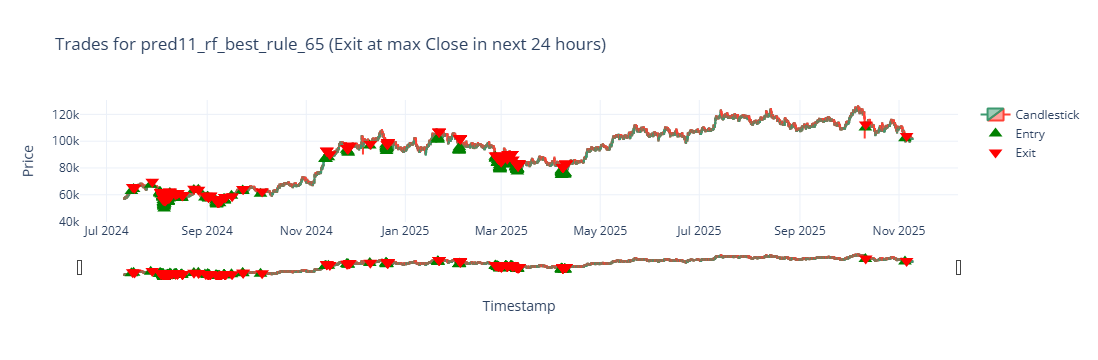

In [137]:
test_df = new_df[(new_df["split"] == "test")&(new_df["Ticker_BTC"] == 1)]
plot_trades_on_candlestick(test_df, "pred11_rf_best_rule_65", "candlestick_trades_BTCtestOnly.html")

# **Simulations**

## **Investing $50 on every positive prediction**


- create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"
- fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [6]:
[g for g in new_df.keys() if (g.find('pred')==0)]

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_sma50',
 'pred3_manual_prev_g1_and_sma200',
 'pred4_clf_13',
 'pred5_clf_4',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65',
 'pred12_xgc_best_rule_55',
 'pred13_xgc_best_rule_65']

In [4]:
# current prediction
pred = 'pred6_clf_best'

In [5]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close.count()
     

34905

In [6]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

486

In [7]:
new_df.keys().to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'growth_1h',
 'growth_4h',
 'growth_8h',
 'growth_24h',
 'growth_120h',
 'growth_360h',
 'EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'growing_moving_average',
 'high_minus_low_relative',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative',
 'returns',
 'volatility',
 'Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht

In [8]:
# growth indicators (but not future growth)
GROWTH = [g for g in new_df.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1h',
 'growth_4h',
 'growth_8h',
 'growth_24h',
 'growth_120h',
 'growth_360h']

In [9]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Volume']

In [10]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker']

In [11]:
TO_PREDICT = [g for g in new_df.keys() if (g.find('future')>=0)]
TO_PREDICT

['Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future']

In [85]:
# What we're trying to predict?
to_predict = 'is_positive_growth_24h_future'


In [12]:
# MAIN GOAL HERE IS TO MAKE SURE THAT 'OTHER' list is empty - we should categorize all feautures
# dropping some features - artifacts from joins, CATEGORICAL (to be converted to dummies), OHLCV
# 'index_x', 'index_y', 'index','Adj Close_y'
TO_DROP = ['Year','Date', 'returns'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'returns',
 'Month',
 'Weekday',
 'Ticker',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume']

In [13]:
MAs = [g for g in new_df.keys() if (g.find('MA')>=0)]
MAs

['EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative']

In [14]:
# manually defined features
# 'Dividends' and 'Stock Splits' - absolute values of Divs and Splits.
# is_stock_split, is_div_payout - dummies on the dates when Divs and Splits are >0
CUSTOM_NUMERICAL = MAs + ['growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']   

In [15]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
     


In [16]:
TECHNICAL_PATTERNS = [g for g in new_df.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')
     

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [17]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL

In [18]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(new_df[CATEGORICAL], dtype='int32')

In [19]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_1',
 'Month_10',
 'Month_11',
 'Month_12',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_BTC',
 'Ticker_ETH',
 'Ticker_XRP']

In [20]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in new_df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT + DUMMIES]
OTHER

['split',
 'pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_sma50',
 'pred3_manual_prev_g1_and_sma200',
 'is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'pred4_clf_13',
 'is_correct_pred4',
 'pred5_clf_2',
 'pred6_clf_best',
 'is_correct_pred5',
 'is_correct_pred6',
 'proba_pred8',
 'pred8_clf_second_best_rule_84',
 'proba_pred9',
 'pred9_clf_second_best_rule_92',
 'proba_pred10',
 'pred10_rf_best_rule_55',
 'proba_pred11',
 'pred11_rf_best_rule_65',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [21]:
new_df.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'growth_1h',
 'growth_4h',
 'growth_8h',
 'growth_24h',
 'growth_120h',
 'growth_360h',
 'EMA10',
 'EMA20',
 'SMA50',
 'SMA200',
 'growing_moving_average',
 'high_minus_low_relative',
 'high_touching_SMA50_relative',
 'low_touching_SMA50_relative',
 'high_touching_SMA200_relative',
 'low_touching_SMA200_relative',
 'returns',
 'volatility',
 'Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht

In [22]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT
     

['Max_Price_in_future_24h',
 'growth_future_24h',
 'is_positive_growth_24h_future']

In [23]:
# Sample
new_df[['growth_future_24h','is_positive_growth_24h_future',pred]].sample(5)

,growth_future_24h,is_positive_growth_24h_future,pred6_clf_best
2023-08-13 12:00:00+00:00,1.001765,0,0
2018-05-06 04:00:00+00:00,1.000000,0,1
2019-05-19 12:00:00+00:00,1.075000,1,1
2018-05-27 12:00:00+00:00,1.016667,1,1
2018-09-20 01:00:00+00:00,1.070272,1,1


In [7]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_sma50',
 'pred3_manual_prev_g1_and_sma200',
 'pred4_clf_13',
 'pred5_clf_4',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65',
 'pred12_xgc_best_rule_55',
 'pred13_xgc_best_rule_65']

In [25]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int) # Key logic ZB11092025

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [26]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and EXIT (sell) at the maximum Close within 24h! 
# Tricky to execute in practical!
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_24h']-1)

In [27]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [28]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [30]:
# sample of individual results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(5)

,Date,Ticker,Close,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
2024-09-05 21:00:00+00:00,2024-09-05,XRP,0.540000,0.550000,1.018519,1,1,1.851852,-0.2,1.651852
2024-10-01 05:00:00+00:00,2024-10-01,ETH,2640.010000,2657.070000,1.006462,0,1,0.646210,-0.2,0.446210
2025-01-24 13:00:00+00:00,2025-01-24,BTC,105044.000000,106429.400000,1.013189,1,1,1.318876,-0.2,1.118876
2025-11-06 19:00:00+00:00,2025-11-06,ETH,3327.221436,3426.135986,1.029729,1,1,2.972888,-0.2,2.772888
2025-06-07 06:00:00+00:00,2025-06-07,ETH,2501.550000,2536.110000,1.013815,1,1,1.381543,-0.2,1.181543


In [31]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)
     

56.0


In [32]:
new_df[filter_test_and_positive_pred].groupby('Date')[pred].count()

Date
2024-07-12    46
2024-07-13    19
2024-07-14    20
2024-07-15    47
2024-07-16    70
              ..
2025-11-04    64
2025-11-05    67
2025-11-06    56
2025-11-07    51
2025-11-08    42
Name: pred6_clf_best, Length: 477, dtype: int64

In [33]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T
     

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,477.0,43.830189,18.379819,1.0,32.0,48.0,56.0,72.0


In [35]:
pred

'pred6_clf_best'

In [36]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()
     

sim1_gross_rev_pred6    55032.754811
sim1_fees_pred6         -4181.400000
sim1_net_rev_pred6      50851.354811
dtype: float64

In [13]:
test_days = new_df[new_df.split == 'test']['Date'].nunique()
test_years = round(test_days / 365, 2)
test_years

1.33

In [113]:
pred

'pred11_rf_best_rule_65'

In [106]:
new_df[(new_df.split=='test')&(new_df[pred]==1)].groupby('Date').count()

,Open,High,Low,Close,Volume,Ticker,Year,Month,Weekday,growth_1h,...,sim1_fees_pred9,sim1_net_rev_pred9,sim1_gross_rev_pred10,sim1_fees_pred10,sim1_net_rev_pred10,sim1_gross_rev_pred11,sim1_fees_pred11,sim1_net_rev_pred11,pred8_rank,pred10_rank
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2024-07-13,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
2024-07-14,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2024-07-15,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2024-07-16,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
2025-11-05,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2025-11-06,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [114]:
new_df[(new_df.split=='test')&(new_df[pred]==1)&(new_df.Date == datetime.date(2025,11,4))]

,Open,High,Low,Close,Volume,Ticker,Year,Month,Weekday,Date,...,sim1_fees_pred9,sim1_net_rev_pred9,sim1_gross_rev_pred10,sim1_fees_pred10,sim1_net_rev_pred10,sim1_gross_rev_pred11,sim1_fees_pred11,sim1_net_rev_pred11,pred8_rank,pred10_rank
2025-11-04 16:00:00+00:00,103218.929688,103445.093750,102204.007812,102204.007812,0.000000e+00,BTC,2025,11,1,2025-11-04,...,0.0,0.000000,1.450049,-0.2,1.250049,1.450049,-0.2,1.250049,60.0,35.0
2025-11-04 00:00:00+00:00,3602.629395,3629.424072,3569.583008,3613.873779,2.964316e+08,ETH,2025,11,1,2025-11-04,...,-0.2,0.648895,0.848895,-0.2,0.648895,0.848895,-0.2,0.648895,30.0,23.0
2025-11-04 01:00:00+00:00,3616.909180,3647.433105,3612.608154,3643.862305,0.000000e+00,ETH,2025,11,1,2025-11-04,...,-0.2,-0.181079,0.018921,-0.2,-0.181079,0.018921,-0.2,-0.181079,31.0,39.0
2025-11-04 02:00:00+00:00,3639.904297,3646.495605,3621.992920,3628.216797,0.000000e+00,ETH,2025,11,1,2025-11-04,...,-0.2,0.250220,0.450220,-0.2,0.250220,0.450220,-0.2,0.250220,32.0,31.0
2025-11-04 03:00:00+00:00,3625.751709,3649.646729,3622.571777,3644.551758,0.000000e+00,ETH,2025,11,1,2025-11-04,...,-0.2,-0.200000,0.000000,-0.2,-0.200000,0.000000,-0.2,-0.200000,33.0,36.0
2025-11-04 04:00:00+00:00,3642.115967,3645.869141,3622.378662,3624.907227,0.000000e+00,ETH,2025,11,1,2025-11-04,...,-0.2,-0.200000,0.000000,-0.2,-0.200000,0.000000,-0.2,-0.200000,34.0,30.0
2025-11-04 06:00:00+00:00,3493.156006,3555.231445,3489.392822,3505.156006,1.978139e+09,ETH,2025,11,1,2025-11-04,...,-0.2,1.104614,1.304614,-0.2,1.104614,1.304614,-0.2,1.104614,2.0,6.0
2025-11-04 07:00:00+00:00,3511.444580,3511.444580,3476.182861,3491.633789,1.954959e+09,ETH,2025,11,1,2025-11-04,...,-0.2,1.496941,1.696941,-0.2,1.496941,1.696941,-0.2,1.496941,3.0,18.0
2025-11-04 08:00:00+00:00,3492.430908,3507.856689,3462.038086,3492.354492,2.930647e+08,ETH,2025,11,1,2025-11-04,...,-0.2,1.475955,1.675955,-0.2,1.475955,1.675955,-0.2,1.475955,4.0,15.0
2025-11-04 09:00:00+00:00,3493.564941,3496.263672,3479.284180,3490.321045,0.000000e+00,ETH,2025,11,1,2025-11-04,...,-0.2,1.535191,1.735191,-0.2,1.535191,1.735191,-0.2,1.535191,36.0,42.0


In [14]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_24h']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
      sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * sim1_q75_investments_per_day # ZB 24h in a row with positive predictions. 
    # Capital should reflect the maximum cash needed at the same time, not the total amount transacted over the entire test period.

  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/test_years)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST ({test_years} years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)
     

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 956 out of 34761 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    2212.908321
sim1_fees_pred0         -191.200000
sim1_net_rev_pred0      2021.708321
dtype: float64
        Count Investments in 4 years (on TEST): 956
        Gross Revenue: $2212
        Fees (0.2% for buy+sell): $191
        Net Revenue: $2021
        Fees are 8 % from Gross Revenue
        Capital Required : $400 (Vbegin)
        Final value (Vbegin + Net_revenue) : $2421 (Vfinal)
        Average CAGR on TEST (1.33 years) : 3.873, or 287.3% 
        Average daily stats: 
            Average net revenue per investment: $2.11 
            Average investments per day: 3 
            Q75 investments per day: 4 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 17168 out of 34761 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    3

In [15]:
df_sim1_results[f'sim1_growth_capital_{test_years}y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital
     

In [16]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_1.33y
0,pred0_manual_cci,956,2212.908321,-191.2,2021.708321,0.086402,2.114758,3.093851,400.0,3.872723,6.054271
1,pred1_manual_prev_g1,17168,36481.590467,-3433.6,33047.990467,0.094119,1.924976,36.683761,5400.0,4.374841,7.119998
2,pred2_manual_prev_g1_and_sma50,39,138.262790,-7.8,130.462790,0.056414,3.345200,2.052632,300.0,1.311915,1.434876
3,pred3_manual_prev_g1_and_sma200,1199,3158.713904,-239.8,2918.913904,0.075917,2.434457,11.419048,1600.0,2.182897,2.824321
4,pred4_clf_13,23943,58566.849065,-4788.6,53778.249065,0.081763,2.246095,49.469008,5900.0,5.696552,10.114957
5,pred5_clf_4,20088,53160.691667,-4017.6,49143.091667,0.075575,2.446390,42.923077,5500.0,5.620226,9.935108
6,pred6_clf_best,18327,49492.048011,-3665.4,45826.648011,0.074060,2.500499,40.190789,5325.0,5.479638,9.605943
7,pred8_clf_second_best_rule_84,18327,49492.048011,-3665.4,45826.648011,0.074060,2.500499,40.190789,5325.0,5.479638,9.605943
8,pred9_clf_second_best_rule_92,18327,49492.048011,-3665.4,45826.648011,0.074060,2.500499,40.190789,5325.0,5.479638,9.605943
9,pred10_rf_best_rule_55,18192,50254.089960,-3638.4,46615.689960,0.072400,2.562428,37.900000,4800.0,5.947393,10.711602


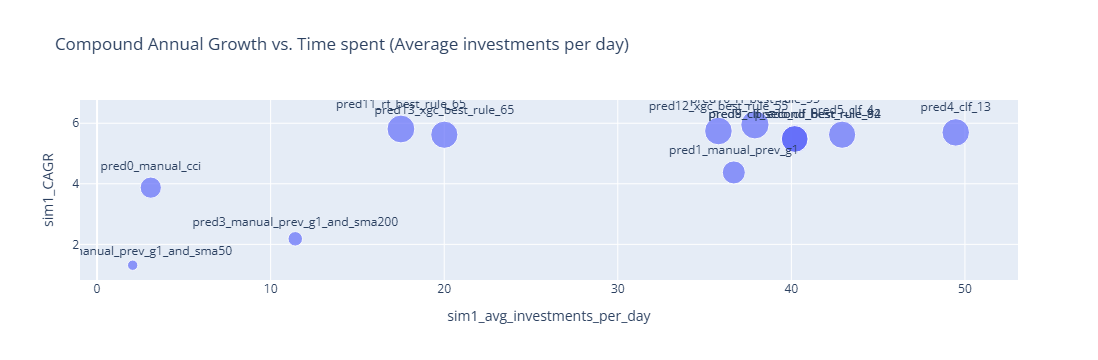

In [17]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size=f'sim1_growth_capital_{test_years}y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', f'growth_capital_{test_years}y': f'{test_years}-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()
     


In [55]:

# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred10_rf_best_rule_55'])]
     

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
9,pred10_rf_best_rule_55,16893,48063.561437,-3378.6,44684.961437,0.070294,2.645176,34.975155,4600.0,5.936453,10.714122


In [56]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92','pred5_clf_13'])]
     

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
8,pred9_clf_second_best_rule_92,12508,38722.18431,-2501.6,36220.58431,0.064604,2.895793,29.088372,4600.0,5.153075,8.87404


## **Advanced Simulations**

In [22]:
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
# rank of prediction

new_df["pred8_rank"] = new_df.groupby("Date")["proba_pred8"].rank(method="first", ascending=False)

new_df["pred10_rank"] = new_df.groupby("Date")["proba_pred10"].rank(method="first", ascending=False)


In [23]:
"""
groupby("Date"): splits your DataFrame into groups by each unique Date.
["proba_pred10"]: selects the column you want to rank within each group.
.rank(method="first", ascending=False):
ascending=False: larger values get smaller rank numbers (so the largest probability = rank 1).
method="first": if there are ties, the one that appears first in the DataFrame gets the lower rank.
The result is a Series aligned with your DataFrame’s index, containing the rank of each row’s proba_pred10 within its date.
"""

new_df.groupby("Date")["proba_pred10"].rank(method="first", ascending=False)


2017-01-16 00:00:00+00:00    42.0
2017-01-16 01:00:00+00:00    41.0
2017-01-16 02:00:00+00:00    43.0
2017-01-16 03:00:00+00:00    39.0
2017-01-16 04:00:00+00:00    11.0
                             ... 
2025-11-13 01:00:00+00:00    10.0
2025-11-13 02:00:00+00:00    12.0
2025-11-13 03:00:00+00:00     4.0
2025-11-13 04:00:00+00:00     1.0
2025-11-13 05:00:00+00:00     2.0
Name: proba_pred10, Length: 231211, dtype: float64

In [24]:
new_df.Date

2017-01-16 00:00:00+00:00    2017-01-16
2017-01-16 01:00:00+00:00    2017-01-16
2017-01-16 02:00:00+00:00    2017-01-16
2017-01-16 03:00:00+00:00    2017-01-16
2017-01-16 04:00:00+00:00    2017-01-16
                                ...    
2025-11-13 01:00:00+00:00    2025-11-13
2025-11-13 02:00:00+00:00    2025-11-13
2025-11-13 03:00:00+00:00    2025-11-13
2025-11-13 04:00:00+00:00    2025-11-13
2025-11-13 05:00:00+00:00    2025-11-13
Name: Date, Length: 231211, dtype: object

In [25]:
# CHECK RANK FOR 1 DAY:
  # we have predictions for all 112 stocks
import datetime
first_trading_day_2024 = new_df[new_df.Date>= datetime.date(2024, 1, 4)].Date.unique().astype(str)[0]
first_trading_day_2024
print(f'First trading day in 2024: {first_trading_day_2024}, count predictions = {len(new_df[new_df.Date==first_trading_day_2024])}')
     

First trading day in 2024: 2024-01-04, count predictions = 0


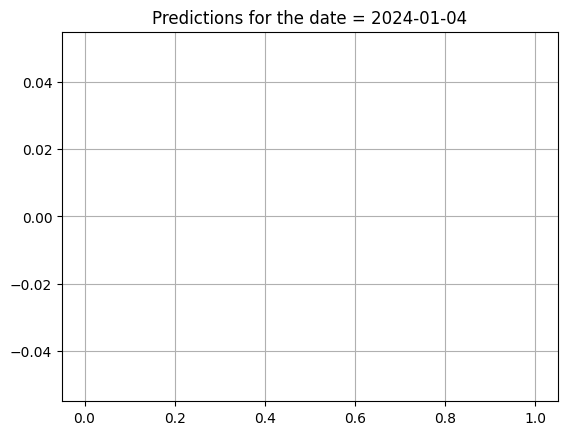

In [26]:
# Decision Tree's predictions are not very smooth - either too small or too big
new_df[new_df.Date==first_trading_day_2024].proba_pred8.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()
     

In [27]:
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker', 'Close','proba_pred8','pred8_rank']].sort_values(by='pred8_rank').head(5)
     

,Date,Ticker,Close,proba_pred8,pred8_rank


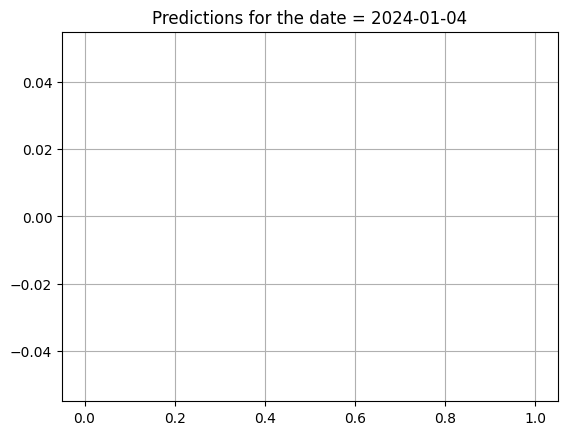

In [28]:

# Random Forest's predictions are more spreaded across the range - rank() function will work
new_df[new_df.Date==first_trading_day_2024].proba_pred10.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()
     

In [52]:
# It is quite different vs. a single Decision tree (proba_pred9 vs. proba_pred10)
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker', 'Close','proba_pred8','proba_pred10','pred10_rank']].sort_values(by='pred10_rank').head(5)
     

,Date,Ticker,Close,proba_pred8,proba_pred10,pred10_rank
4214,2024-01-04,BND,68.802109,1.000000,0.526982,1.0
6039,2024-01-04,ORCL,100.526596,0.100546,0.515527,2.0
6039,2024-01-04,T,15.623886,0.100546,0.509233,3.0
6039,2024-01-04,WMT,51.576057,0.100546,0.507405,4.0
685,2024-01-04,APP,38.119999,0.100546,0.500627,5.0


In [53]:
# Sort the DataFrame by Ticker and Date
new_df = new_df.sort_values(by=['Ticker', 'Date'])

In [54]:
new_df['growth_future_30d'].describe().T

count    615480.000000
mean          1.019894
std           0.114126
min           0.177273
25%           0.962734
50%           1.017893
75%           1.073361
max           3.993296
Name: growth_future_30d, dtype: float64

In [55]:
# take profit if growth >=20%
new_df['growth_future_30d'].quantile(0.95)

np.float64(1.1891650124605908)

In [56]:
# stop loss when -11%
new_df['growth_future_30d'].quantile(0.1)

np.float64(0.900928228163064)

In [58]:
# check a sample on the test dataset
new_df[new_df.split=='test'][['Date','High','Low','Close','Ticker','ticker_type','growth_future_30d']].sample(10)
     

,Date,High,Low,Close,Ticker,ticker_type,growth_future_30d
1620,2021-10-25,143.899994,139.501007,142.516006,SHOP,biggest_company,1.066905
72,2023-12-27,74.760002,73.410004,74.250000,ARM,biggest_company,1.551650
5887,2023-05-26,51.919998,50.930000,51.060001,BSX,biggest_company,1.027419
5767,2022-12-02,163.693768,160.395456,161.376038,CVX,biggest_company,0.979009
6003,2023-11-10,270.778710,262.612928,269.194733,SYK,biggest_company,1.093012
6217,2024-09-19,207.255901,202.786263,205.857300,JPM,biggest_company,1.060813
5758,2022-11-18,48.197941,47.726355,48.194733,WMT,biggest_company,0.960540
3990,2023-02-13,66.920082,66.736918,66.920082,BND,commodity_fund,1.005024
6026,2023-12-14,32.822744,31.377657,32.697502,BAC,biggest_company,1.025044
5912,2023-12-15,327.000000,322.589996,324.350006,ISRG,biggest_company,1.166086


In [76]:
# Define a function to get the rolling max High and min Low for the next 30 trading days

# Sort the DataFrame: Sorting by Ticker and Date ensures that we are looking at each ticker's data in chronological order.
# Rolling window calculation: We use the rolling method with a window of 5 to calculate the maximum high and minimum low over the next 5 days.
# The shift method is used to align these values correctly with the current row.

def rolling_max_min(df, window=30):
    # high/low in 30 days
    df['Max_High_Next_30'] = df['High'].rolling(window=window, min_periods=1).max().shift(-window+1)
    df['Min_Low_Next_30'] = df['Low'].rolling(window=window, min_periods=1).min().shift(-window+1)

    # low in 1 day (for lower entry)
    df['Min_Low_Next_1'] = df['Low'].rolling(window=1, min_periods=1).min().shift(-1)
    return df

In [77]:
# Apply the function to each group of Ticker
# Important!: need to drop index from groupby operation (reset_index) - so that you can merge that afterwards
result = new_df[new_df.split=='test'][['Date','High','Low','Close','Ticker']].groupby('Ticker').apply(rolling_max_min).reset_index(drop=True)
result.head(30)
     

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
0,2024-07-12,57546.83,57128.05,57147.51,BTC,58532.48,56525.00,56525.00
1,2024-07-12,57327.97,56525.00,56921.01,BTC,58532.48,56525.00,56864.05
2,2024-07-12,57391.84,56864.05,57363.89,BTC,58532.48,56702.50,56856.00
3,2024-07-12,57363.96,56856.00,56896.50,BTC,58532.48,56702.50,56702.50
4,2024-07-12,57054.98,56702.50,57025.16,BTC,58851.98,56702.50,56933.01
5,2024-07-12,57105.49,56933.01,57018.35,BTC,58851.98,56766.00,57014.88
6,2024-07-12,57398.49,57014.88,57224.67,BTC,58851.98,56766.00,56826.50
7,2024-07-12,57297.46,56826.50,57073.52,BTC,58886.96,56766.00,57010.50
8,2024-07-12,57320.48,57010.50,57304.05,BTC,58886.96,56766.00,56873.53
9,2024-07-12,57339.46,56873.53,56955.97,BTC,58886.96,56766.00,56766.00


In [79]:
result[result.Ticker=='BTC'].tail(30)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
11605,2025-11-08,103359.062500,102613.757812,102696.007812,BTC,103359.0625,101463.195312,102617.695312
11606,2025-11-08,103147.140625,102617.695312,102935.203125,BTC,NaN,NaN,102728.140625
11607,2025-11-08,103254.578125,102728.140625,102831.546875,BTC,NaN,NaN,102569.507812
11608,2025-11-08,103237.398438,102569.507812,102600.039062,BTC,NaN,NaN,102383.750000
11609,2025-11-08,102748.406250,102383.750000,102474.804688,BTC,NaN,NaN,102283.078125
11610,2025-11-08,102659.265625,102283.078125,102293.164062,BTC,NaN,NaN,102136.828125
11611,2025-11-08,102468.031250,102136.828125,102182.085938,BTC,NaN,NaN,101911.601562
11612,2025-11-08,102333.812500,101911.601562,102301.414062,BTC,NaN,NaN,102146.070312
11613,2025-11-08,102619.507812,102146.070312,102421.281250,BTC,NaN,NaN,102213.054688
11614,2025-11-08,102545.335938,102213.054688,102347.804688,BTC,NaN,NaN,102263.835938


In [80]:
# Calculate the ratios + safe divide
result['Ratio_MaxHighNext30_to_Close'] = np.where(
                                                  result['Close'] == 0,                  # condition
                                                  np.nan,                                # value if condition is True
                                                  result['Max_High_Next_30'] / result['Close']  # value if condition is False
)

# use .where or .mask, which often reads cleaner. # >0 If some Close are negative (e.g., data errors)
# result['Ratio_MaxHighNext30_to_Close'] = (result['Max_High_Next_30'] / result['Close']).where(result['Close'] != 0) 


result['Ratio_MinLowNext30_to_Close'] =  np.where(result['Close'] == 0, np.nan,  result['Min_Low_Next_30']/result['Close'])

result['Ratio_MinLowNext1_to_Close'] =  np.where(result['Close'] == 0, np.nan,  result['Min_Low_Next_1']/result['Close'])

In [63]:
result[result.Ticker=='AAPL'].head(10)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
0,2021-10-21,146.493630,144.760842,146.336990,AAPL,166.962643,143.331623,145.514723,1.140946,0.979463,0.994381
1,2021-10-22,147.022337,145.514723,145.563675,AAPL,166.962643,143.331623,144.516167,1.147008,0.984666,0.992804
2,2021-10-25,146.229372,144.516167,145.514725,AAPL,166.962643,143.331623,145.876941,1.147393,0.984997,1.002489
3,2021-10-26,147.668465,145.876941,146.180435,AAPL,168.217533,143.331623,145.367860,1.150753,0.980512,0.994441
4,2021-10-27,146.581778,145.367860,145.720291,AAPL,172.511716,143.331623,146.572024,1.183855,0.983608,1.005845
5,2021-10-28,149.949482,146.572024,149.362106,AAPL,173.286199,143.331623,143.331623,1.160175,0.959625,0.959625
6,2021-10-29,146.787401,143.331623,146.650345,AAPL,176.109784,143.331623,144.692374,1.200882,0.977370,0.986649
7,2021-11-01,146.552419,144.692374,145.827988,AAPL,178.560811,144.589823,145.524488,1.224462,0.991509,0.997919
8,2021-11-02,148.383105,145.524488,146.865692,AAPL,178.560811,144.589823,146.669909,1.215810,0.984504,0.998667
9,2021-11-03,148.774698,146.669909,148.304794,AAPL,178.560811,144.589823,147.472640,1.204012,0.974950,0.994389


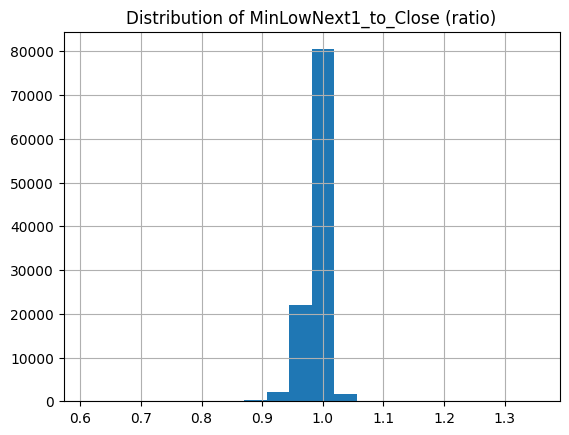

In [64]:
result.Ratio_MinLowNext1_to_Close.hist(bins=20)
plt.title(f'Distribution of MinLowNext1_to_Close (ratio)')
# Show the plot
plt.show()

In [65]:
result.Ratio_MinLowNext1_to_Close.describe().T

count    106882.000000
mean          0.988867
std           0.018208
min           0.609592
25%           0.982605
50%           0.991782
75%           0.998246
max           1.353308
Name: Ratio_MinLowNext1_to_Close, dtype: float64

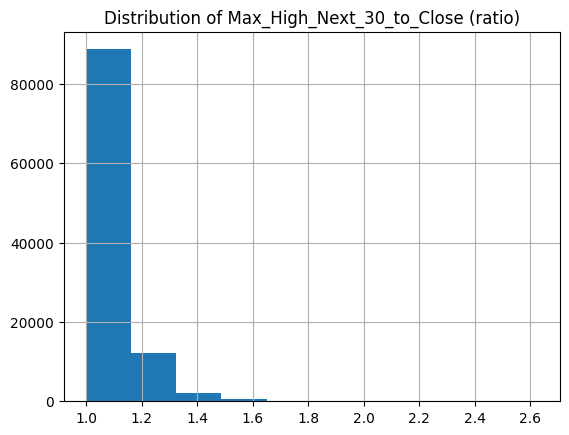

In [66]:

result.Ratio_MaxHighNext30_to_Close.hist()
plt.title(f'Distribution of Max_High_Next_30_to_Close (ratio)')
# Show the plot
plt.show()

In [67]:
result.Ratio_MaxHighNext30_to_Close.describe().T

count    103746.000000
mean          1.092269
std           0.093116
min           1.000000
25%           1.032423
50%           1.067881
75%           1.121983
max           2.624819
Name: Ratio_MaxHighNext30_to_Close, dtype: float64

In [68]:
result[result.Ratio_MaxHighNext30_to_Close>=1.3].sample(5)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
9411,2024-09-12,106.449997,97.349998,105.610001,APP,165.380005,97.349998,105.940002,1.565950,0.921788,1.003125
67936,2023-10-27,112.769997,107.669998,108.279999,PDD,147.649994,97.940002,104.000000,1.363594,0.904507,0.960473
5366,2023-12-15,140.889999,137.250000,139.149994,AMD,184.919998,133.740005,137.649994,1.328926,0.961121,0.989220
98382,2022-02-04,65.349998,64.650002,64.910004,USO,87.839996,62.849998,64.470001,1.353258,0.968264,0.993221
35534,2025-06-16,492.315695,479.791148,487.667725,GEV,655.650024,478.831577,481.390462,1.344461,0.981881,0.987128


In [69]:
# ~1.8% cases TAKE PROFIT (30%)
len(result[result.Ratio_MaxHighNext30_to_Close>=1.3])/len(result)

0.0319737555376937

<Axes: >

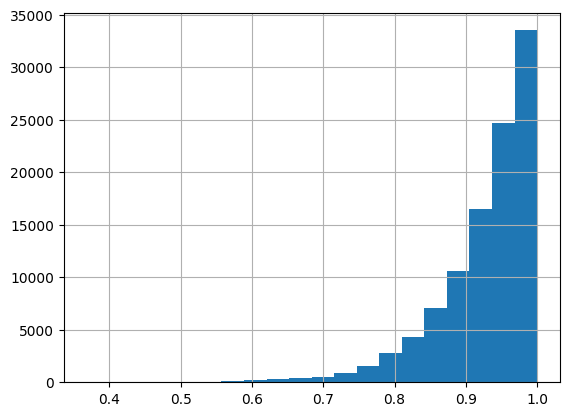

In [70]:
# High intra-day volatility, especially on earlier days after the IPO
result.Ratio_MinLowNext30_to_Close.hist(bins=20)

In [71]:
result.Ratio_MinLowNext30_to_Close.describe().T

count    103746.000000
mean          0.925743
std           0.069022
min           0.367247
25%           0.897050
50%           0.946250
75%           0.975696
max           1.000000
Name: Ratio_MinLowNext30_to_Close, dtype: float64

In [72]:
result[result.Ratio_MinLowNext30_to_Close<=0.8].sample(5)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
75353,2022-08-15,101.694563,99.541282,101.367722,REMX,101.694563,80.546249,98.531928,1.003224,0.794595,0.972025
60390,2024-07-10,10.823783,10.765901,10.794842,MUFG,11.306128,8.441008,10.698375,1.047364,0.781948,0.991064
15079,2022-04-06,103.963116,100.781639,102.263161,BABA,103.963116,74.085710,97.448214,1.016623,0.724461,0.952916
27383,2025-02-26,198.405011,194.229741,195.611557,COF,201.059296,142.376813,195.104535,1.027850,0.727855,0.997408
9015,2023-02-14,16.219999,15.170000,15.970000,APP,17.014999,11.690000,15.790000,1.065435,0.731997,0.988729


In [73]:
# ~0.8% STOP LOSS
len(result[result.Ratio_MinLowNext30_to_Close<=0.8])/len(result)

0.055816213993308036

In [74]:
# Merge the results back with the original dataframe
new_df = new_df.merge(result[['Date', 'Ticker', 'Max_High_Next_30', 'Min_Low_Next_30','Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']], on=['Date', 'Ticker'])
     

In [75]:
new_df.sample(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,sim1_gross_rev_pred11,sim1_fees_pred11,sim1_net_rev_pred11,pred10_rank,pred8_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
75208,109.471375,111.115175,108.625445,110.548019,149100.0,0.0,0.0,commodity_fund,REMX,2022,...,-0.0,0.0,0.0,70.0,109.0,111.115175,90.745499,1.005130,0.820870,0.970000
64361,134.158324,134.378290,130.398937,131.978683,237951100.0,0.0,0.0,biggest_company,NVDA,2024,...,-0.0,0.0,0.0,15.0,4.0,153.105279,116.231243,1.160076,0.880682,0.961061
20398,68.692279,68.739688,68.578485,68.720726,7603100.0,0.0,0.0,commodity_fund,BND,2024,...,-0.0,0.0,0.0,3.0,1.0,68.986269,66.928429,1.003864,0.973919,1.000690
96529,39.255547,39.389617,39.130416,39.166168,3811500.0,0.0,0.0,biggest_company,UL,2022,...,0.0,0.0,0.0,15.0,98.0,43.349133,38.576249,1.106800,0.984938,0.997261
80138,57.527586,58.214711,57.069503,58.081104,9045900.0,0.0,0.0,biggest_company,SCHW,2022,...,0.0,0.0,0.0,72.0,94.0,67.061436,56.869096,1.154617,0.979132,0.984555


In [18]:
from dataclasses import dataclass

@dataclass
class SimulationParams:
    initial_capital: float
    threshold: float
    fees: float
    top_k: int
    portfolio_optimization: bool
    stop_loss: float
    take_profit: float
    lower_entry: float
     

# Example of initializing with some values
sim_params = SimulationParams(
    initial_capital=10000,        # initial capital = $10k
    threshold=0.55,               # select all binary predictions with probability>=0.55
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -20% from Close
    take_profit=1.3,              # automatic sell (with profit) if price (any of next 30 days) is higher than +30% from Close
    lower_entry= 0.995                # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

print(sim_params)
     

SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.995)


In [19]:
# sorted array of dates for Simulation
DATES = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
print(f' Min date {DATES.min()}, max date {DATES.max()}')
     

 Min date 2024-07-18, max date 2025-11-13


In [20]:
date = DATES[0]
date

datetime.date(2024, 7, 18)

In [21]:
# 1. get TOP_K predictions from pred10_rf_best_rule_50, that are higher than THE THRESHOLD
if sim_params.top_k is None:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred10 > sim_params.threshold)]
else:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred10 > sim_params.threshold)&(new_df.pred10_rank<=sim_params.top_k)]
     

AttributeError: 'DataFrame' object has no attribute 'pred10_rank'

In [91]:
one_day_predictions_df[['Date','Ticker',to_predict,'growth_future_24h','proba_pred10','pred10_rank']]

,Date,Ticker,is_positive_growth_24h_future,growth_future_24h,proba_pred10,pred10_rank
2024-07-12 03:00:00+00:00,2024-07-12,BTC,1,1.024752,0.639873,6.0
2024-07-12 07:00:00+00:00,2024-07-12,ETH,1,1.023199,0.621814,10.0
2024-07-12 09:00:00+00:00,2024-07-12,ETH,1,1.027567,0.639519,7.0
2024-07-12 00:00:00+00:00,2024-07-12,XRP,1,1.044444,0.637037,8.0
2024-07-12 05:00:00+00:00,2024-07-12,XRP,1,1.111111,0.651471,5.0
2024-07-12 09:00:00+00:00,2024-07-12,XRP,1,1.130435,0.718230,3.0
2024-07-12 14:00:00+00:00,2024-07-12,XRP,1,1.130435,0.737770,1.0
2024-07-12 15:00:00+00:00,2024-07-12,XRP,1,1.130435,0.626855,9.0
2024-07-12 22:00:00+00:00,2024-07-12,XRP,1,1.191489,0.683450,4.0
2024-07-12 23:00:00+00:00,2024-07-12,XRP,1,1.191489,0.722874,2.0


In [92]:
# 2. Get non-normalized weights: probability-threshold + 0.01
one_day_predictions_df['weight'] = one_day_predictions_df.proba_pred10 - sim_params.threshold +0.01

In [93]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_24h','proba_pred10','pred10_rank','weight']]
     

,Date,Ticker,Close,is_positive_growth_24h_future,growth_future_24h,proba_pred10,pred10_rank,weight
2024-07-12 03:00:00+00:00,2024-07-12,BTC,56896.50,1,1.024752,0.639873,6.0,0.099873
2024-07-12 07:00:00+00:00,2024-07-12,ETH,3072.10,1,1.023199,0.621814,10.0,0.081814
2024-07-12 09:00:00+00:00,2024-07-12,ETH,3059.04,1,1.027567,0.639519,7.0,0.099519
2024-07-12 00:00:00+00:00,2024-07-12,XRP,0.45,1,1.044444,0.637037,8.0,0.097037
2024-07-12 05:00:00+00:00,2024-07-12,XRP,0.45,1,1.111111,0.651471,5.0,0.111471
2024-07-12 09:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.718230,3.0,0.178230
2024-07-12 14:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.737770,1.0,0.197770
2024-07-12 15:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.626855,9.0,0.086855
2024-07-12 22:00:00+00:00,2024-07-12,XRP,0.47,1,1.191489,0.683450,4.0,0.143450
2024-07-12 23:00:00+00:00,2024-07-12,XRP,0.47,1,1.191489,0.722874,2.0,0.182874


In [95]:
# 3. Get normalized weights
one_day_predictions_df['weight_norm'] = one_day_predictions_df['weight']/one_day_predictions_df['weight'].sum()
     

In [96]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_24h','proba_pred10','pred10_rank','weight','weight_norm']]
     

,Date,Ticker,Close,is_positive_growth_24h_future,growth_future_24h,proba_pred10,pred10_rank,weight,weight_norm
2024-07-12 03:00:00+00:00,2024-07-12,BTC,56896.50,1,1.024752,0.639873,6.0,0.099873,0.078093
2024-07-12 07:00:00+00:00,2024-07-12,ETH,3072.10,1,1.023199,0.621814,10.0,0.081814,0.063972
2024-07-12 09:00:00+00:00,2024-07-12,ETH,3059.04,1,1.027567,0.639519,7.0,0.099519,0.077817
2024-07-12 00:00:00+00:00,2024-07-12,XRP,0.45,1,1.044444,0.637037,8.0,0.097037,0.075875
2024-07-12 05:00:00+00:00,2024-07-12,XRP,0.45,1,1.111111,0.651471,5.0,0.111471,0.087162
2024-07-12 09:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.718230,3.0,0.178230,0.139363
2024-07-12 14:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.737770,1.0,0.197770,0.154642
2024-07-12 15:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.626855,9.0,0.086855,0.067914
2024-07-12 22:00:00+00:00,2024-07-12,XRP,0.47,1,1.191489,0.683450,4.0,0.143450,0.112167
2024-07-12 23:00:00+00:00,2024-07-12,XRP,0.47,1,1.191489,0.722874,2.0,0.182874,0.142994


In [97]:
# 4. Capital: either 1/30 of initial (assuming you trade every day), or everything that you can sell from 30 days ago
one_day_predictions_df['investment'] = one_day_predictions_df['weight_norm'] * sim_params.initial_capital /24
     

In [98]:
# See the allocation of an 'investment' at a price = 'Adj.Close' * sim_params.lower_entry (e.g. 0.995 - try to buy cheaper)
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_24h','proba_pred10','pred10_rank','weight','weight_norm', 'investment']]
     

,Date,Ticker,Close,is_positive_growth_24h_future,growth_future_24h,proba_pred10,pred10_rank,weight,weight_norm,investment
2024-07-12 03:00:00+00:00,2024-07-12,BTC,56896.50,1,1.024752,0.639873,6.0,0.099873,0.078093,32.538943
2024-07-12 07:00:00+00:00,2024-07-12,ETH,3072.10,1,1.023199,0.621814,10.0,0.081814,0.063972,26.655143
2024-07-12 09:00:00+00:00,2024-07-12,ETH,3059.04,1,1.027567,0.639519,7.0,0.099519,0.077817,32.423672
2024-07-12 00:00:00+00:00,2024-07-12,XRP,0.45,1,1.044444,0.637037,8.0,0.097037,0.075875,31.614750
2024-07-12 05:00:00+00:00,2024-07-12,XRP,0.45,1,1.111111,0.651471,5.0,0.111471,0.087162,36.317604
2024-07-12 09:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.718230,3.0,0.178230,0.139363,58.067778
2024-07-12 14:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.737770,1.0,0.197770,0.154642,64.433968
2024-07-12 15:00:00+00:00,2024-07-12,XRP,0.46,1,1.130435,0.626855,9.0,0.086855,0.067914,28.297590
2024-07-12 22:00:00+00:00,2024-07-12,XRP,0.47,1,1.191489,0.683450,4.0,0.143450,0.112167,46.736394
2024-07-12 23:00:00+00:00,2024-07-12,XRP,0.47,1,1.191489,0.722874,2.0,0.182874,0.142994,59.580825


In [99]:
# 5. Lower Entry: the trade is executed only is Low price for next day is lower than bet
one_day_predictions_df['lower_entry'] = (one_day_predictions_df['Ratio_MinLowNext1_to_Close']<=sim_params.lower_entry).astype(int)
     

KeyError: 'Ratio_MinLowNext1_to_Close'

In [91]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,pred8_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry
2895,325.845580,327.447493,324.827914,327.089417,1520200.0,0.0,0.0,biggest_company,ACN,2021,...,78.0,353.285232,324.827914,1.080088,0.993086,1.003255,0.050563,0.096004,32.001362,0
3860,632.000000,639.169983,629.000000,638.659973,1586600.0,0.0,0.0,biggest_company,ADBE,2021,...,86.0,699.539978,629.000000,1.095325,0.984875,0.993408,0.074241,0.140962,46.987393,1
10139,745.407510,767.861450,744.763985,767.861450,1083100.0,0.0,0.0,biggest_company,ASML,2021,...,27.0,859.081323,744.763985,1.118797,0.969920,1.011059,0.068530,0.130119,43.372858,0
27509,447.785668,455.296904,447.127957,454.896576,1423300.0,0.0,0.0,biggest_company,COST,2021,...,19.0,535.401508,447.127957,1.176974,0.982922,1.002808,0.063425,0.120426,40.142068,0
31369,274.284649,274.284649,263.383050,271.005463,3239729.0,0.0,0.0,biggest_company,DHR,2021,...,87.0,289.276590,246.385188,1.067420,0.909152,0.995913,0.036013,0.068377,22.792478,0
44269,556.445629,565.163270,551.857382,564.597046,729600.0,0.0,0.0,biggest_company,INTU,2021,...,63.0,699.813349,551.857382,1.239492,0.977436,1.002853,0.055686,0.105732,35.244056,0
49094,295.695072,296.103680,293.072322,295.828094,856900.0,0.0,0.0,biggest_company,LIN,2021,...,44.0,323.243329,293.072322,1.092673,0.990685,1.004947,0.050321,0.095545,31.848193,0
54884,338.423403,340.442326,335.956923,340.014679,16354400.0,0.0,0.0,biggest_company,META,2021,...,6.0,351.899443,305.523905,1.034954,0.898561,0.939248,0.037236,0.070701,23.567008,1
58744,297.224935,300.950262,296.441133,300.698700,16918100.0,0.0,0.0,biggest_company,MSFT,2021,...,2.0,338.967969,296.441133,1.127268,0.985841,0.990475,0.044453,0.084404,28.134646,1
97344,411.042415,417.649296,410.645989,417.441650,2465100.0,0.0,0.0,biggest_company,UNH,2021,...,31.0,439.829482,410.645989,1.053631,0.983721,0.995885,0.046205,0.087730,29.243272,0


In [92]:
# 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
one_day_predictions_df['stop_loss'] = (one_day_predictions_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)
     

In [93]:
# 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
one_day_predictions_df['take_profit'] = (one_day_predictions_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

In [94]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit
2895,325.845580,327.447493,324.827914,327.089417,1520200.0,0.0,0.0,biggest_company,ACN,2021,...,324.827914,1.080088,0.993086,1.003255,0.050563,0.096004,32.001362,0,0,0
3860,632.000000,639.169983,629.000000,638.659973,1586600.0,0.0,0.0,biggest_company,ADBE,2021,...,629.000000,1.095325,0.984875,0.993408,0.074241,0.140962,46.987393,1,0,0
10139,745.407510,767.861450,744.763985,767.861450,1083100.0,0.0,0.0,biggest_company,ASML,2021,...,744.763985,1.118797,0.969920,1.011059,0.068530,0.130119,43.372858,0,0,0
27509,447.785668,455.296904,447.127957,454.896576,1423300.0,0.0,0.0,biggest_company,COST,2021,...,447.127957,1.176974,0.982922,1.002808,0.063425,0.120426,40.142068,0,0,0
31369,274.284649,274.284649,263.383050,271.005463,3239729.0,0.0,0.0,biggest_company,DHR,2021,...,246.385188,1.067420,0.909152,0.995913,0.036013,0.068377,22.792478,0,0,0
44269,556.445629,565.163270,551.857382,564.597046,729600.0,0.0,0.0,biggest_company,INTU,2021,...,551.857382,1.239492,0.977436,1.002853,0.055686,0.105732,35.244056,0,0,0
49094,295.695072,296.103680,293.072322,295.828094,856900.0,0.0,0.0,biggest_company,LIN,2021,...,293.072322,1.092673,0.990685,1.004947,0.050321,0.095545,31.848193,0,0,0
54884,338.423403,340.442326,335.956923,340.014679,16354400.0,0.0,0.0,biggest_company,META,2021,...,305.523905,1.034954,0.898561,0.939248,0.037236,0.070701,23.567008,1,0,0
58744,297.224935,300.950262,296.441133,300.698700,16918100.0,0.0,0.0,biggest_company,MSFT,2021,...,296.441133,1.127268,0.985841,0.990475,0.044453,0.084404,28.134646,1,0,0
97344,411.042415,417.649296,410.645989,417.441650,2465100.0,0.0,0.0,biggest_company,UNH,2021,...,410.645989,1.053631,0.983721,0.995885,0.046205,0.087730,29.243272,0,0,0


In [95]:
# future_gross_return, depending on lower_entry, take_profit, stop_loss

import random

def get_future_gross_return(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade, investment is untouched, no fees
    return row['investment']

  # buy trade is filled for ALL next cases:
  if row['take_profit']==1 and row['stop_loss']==1:
    if random.random()>0.5: #assume take_profit event was first
      return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))
    else: #assume stop_loss event was first
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  if row['take_profit']==1: # take some good profit, pay fees
    return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))

  if row['stop_loss']==1: # fix the loss, pay fees
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  # no stop_loss and no take_profit
  if pd.isna(row['growth_future_30d']):
    return row['investment'] # no information on growth in 30 days --> return the same investment in 5 days
  else:
    return row['investment']*(row['growth_future_30d']+(1-sim_params.lower_entry))
     

In [96]:
# fees, depending on lower_entry, take_profit, stop_loss

def get_fees(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade ==> no fees
    return 0

  # pay fees in all other cases
  return -row['investment']*sim_params.fees

In [97]:
# 8. calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
one_day_predictions_df['future_gross_return'] = one_day_predictions_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
one_day_predictions_df['fees'] =  one_day_predictions_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
one_day_predictions_df['future_net_return'] = one_day_predictions_df['future_gross_return'] + one_day_predictions_df['fees']

# OLD code when no stop_loss, take_profit, and if order executed
# one_day_predictions_df['investment'] * one_day_predictions_df['growth_future_5d']
# one_day_predictions_df['fees'] =   - one_day_predictions_df['investment'] * sim_params.fees


In [98]:
# result
one_day_predictions_df
     

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
2895,325.845580,327.447493,324.827914,327.089417,1520200.0,0.0,0.0,biggest_company,ACN,2021,...,1.003255,0.050563,0.096004,32.001362,0,0,0,32.001362,0.000000,32.001362
3860,632.000000,639.169983,629.000000,638.659973,1586600.0,0.0,0.0,biggest_company,ADBE,2021,...,0.993408,0.074241,0.140962,46.987393,1,0,0,45.594189,-0.093975,45.500214
10139,745.407510,767.861450,744.763985,767.861450,1083100.0,0.0,0.0,biggest_company,ASML,2021,...,1.011059,0.068530,0.130119,43.372858,0,0,0,43.372858,0.000000,43.372858
27509,447.785668,455.296904,447.127957,454.896576,1423300.0,0.0,0.0,biggest_company,COST,2021,...,1.002808,0.063425,0.120426,40.142068,0,0,0,40.142068,0.000000,40.142068
31369,274.284649,274.284649,263.383050,271.005463,3239729.0,0.0,0.0,biggest_company,DHR,2021,...,0.995913,0.036013,0.068377,22.792478,0,0,0,22.792478,0.000000,22.792478
44269,556.445629,565.163270,551.857382,564.597046,729600.0,0.0,0.0,biggest_company,INTU,2021,...,1.002853,0.055686,0.105732,35.244056,0,0,0,35.244056,0.000000,35.244056
49094,295.695072,296.103680,293.072322,295.828094,856900.0,0.0,0.0,biggest_company,LIN,2021,...,1.004947,0.050321,0.095545,31.848193,0,0,0,31.848193,0.000000,31.848193
54884,338.423403,340.442326,335.956923,340.014679,16354400.0,0.0,0.0,biggest_company,META,2021,...,0.939248,0.037236,0.070701,23.567008,1,0,0,21.269411,-0.047134,21.222277
58744,297.224935,300.950262,296.441133,300.698700,16918100.0,0.0,0.0,biggest_company,MSFT,2021,...,0.990475,0.044453,0.084404,28.134646,1,0,0,29.437871,-0.056269,29.381602
97344,411.042415,417.649296,410.645989,417.441650,2465100.0,0.0,0.0,biggest_company,UNH,2021,...,0.995885,0.046205,0.087730,29.243272,0,0,0,29.243272,0.000000,29.243272


In [29]:
# Simulation Parameters
sim_params = SimulationParams(
    initial_capital=10000,                 # initial capital = $10k
    threshold=0.55,                        # select all binary predictions with probability>=0.55
    fees=0.002,                            # trading fees = 0.2% (buy+sell)
    top_k=10,                              # select top_k predictions
    portfolio_optimization=False,          # no portfolio optimizaiton
    stop_loss=0.8,                         # automatic sell (with loss) if price (any of next 30 trading days) is lower than -20% from Close
    take_profit=1.3,                       # automatic sell (with profit) if price (any of next 30 trading days) is higher than +30% from Close
    lower_entry= 0.995                     # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

In [30]:
def one_date_simulation(date:str, invest_sum:float, df:pd.DataFrame, sim_params:SimulationParams, predictor:str='proba_pred8'):

  rank_column = predictor.split('_')[1]+'_rank' # e.g. 'proba_pred8' --> 'pred8_rank'
  # 1. get TOP_K (or ALL) predictions from the predictor (pred14_rf_best_rule_53 by default), that are higher than THE THRESHOLD
  if sim_params.top_k is None:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)]
  else:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)&(df[rank_column]<=sim_params.top_k)]

  FIELDS = ['Close', 'Ticker', 'Date', predictor, rank_column, 'growth_future_30d', 'Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']
  result_df = one_day_predictions_df[FIELDS].copy()

  # 2. Get non-normalized weights: probability-threshold + 0.01
  result_df['weight'] = result_df[predictor] - sim_params.threshold +0.01

  # 3. Get normalized weights
  result_df['weight_norm'] = result_df['weight']/result_df['weight'].sum()

  # 4. Make bets to allocate 'invest_sum' across all suitable predictions
  result_df['investment'] = result_df['weight_norm'] * invest_sum

  # 5. Lower Entry: the trade is executed only is Low price for next day is lower than the bet (Adj_Close_today * sim_params.lower_entry)
    # [ONLY TRADES with lower_entry==1 are filled by the exchange]
  result_df['lower_entry'] = (result_df['Ratio_MinLowNext1_to_Close'] <= sim_params.lower_entry).astype(int)

  # 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
  result_df['stop_loss'] = (result_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

  # 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
  result_df['take_profit'] = (result_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

  # 8. Calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
  result_df['future_gross_return'] = result_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
  result_df['fees'] =  result_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
  result_df['future_net_return'] = result_df['future_gross_return'] + result_df['fees']

  return result_df

In [31]:
predictor = 'proba_pred8'
rank = predictor.split('_')[1]+'_rank'
print(rank)

pred8_rank


In [32]:
r = one_date_simulation(date='2021-09-14', invest_sum=sim_params.initial_capital/30, df=new_df, sim_params=sim_params, predictor='proba_pred8')
     

KeyError: "['growth_future_30d', 'Ratio_MaxHighNext30_to_Close', 'Ratio_MinLowNext30_to_Close', 'Ratio_MinLowNext1_to_Close'] not in index"

In [119]:
# initial investment
r.investment.sum()
     

np.float64(0.0)

In [120]:
# result in 30 days (returns+fees)
r.future_net_return.sum()

np.float64(0.0)

In [121]:
all_dates = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
all_dates

<DatetimeArray>
['2021-10-21 00:00:00', '2021-10-22 00:00:00', '2021-10-25 00:00:00',
 '2021-10-26 00:00:00', '2021-10-27 00:00:00', '2021-10-28 00:00:00',
 '2021-10-29 00:00:00', '2021-11-01 00:00:00', '2021-11-02 00:00:00',
 '2021-11-03 00:00:00',
 ...
 '2025-08-13 00:00:00', '2025-08-14 00:00:00', '2025-08-15 00:00:00',
 '2025-08-18 00:00:00', '2025-08-19 00:00:00', '2025-08-20 00:00:00',
 '2025-08-21 00:00:00', '2025-08-22 00:00:00', '2025-08-25 00:00:00',
 '2025-08-26 00:00:00']
Length: 965, dtype: datetime64[ns]

In [122]:
# simulate for all dates but last 5
all_dates[0:-5]
     

<DatetimeArray>
['2021-10-21 00:00:00', '2021-10-22 00:00:00', '2021-10-25 00:00:00',
 '2021-10-26 00:00:00', '2021-10-27 00:00:00', '2021-10-28 00:00:00',
 '2021-10-29 00:00:00', '2021-11-01 00:00:00', '2021-11-02 00:00:00',
 '2021-11-03 00:00:00',
 ...
 '2025-08-06 00:00:00', '2025-08-07 00:00:00', '2025-08-08 00:00:00',
 '2025-08-11 00:00:00', '2025-08-12 00:00:00', '2025-08-13 00:00:00',
 '2025-08-14 00:00:00', '2025-08-15 00:00:00', '2025-08-18 00:00:00',
 '2025-08-19 00:00:00']
Length: 960, dtype: datetime64[ns]

In [123]:
# these last days we only "sell" the positions
all_dates[-5:]

<DatetimeArray>
['2025-08-20 00:00:00', '2025-08-21 00:00:00', '2025-08-22 00:00:00',
 '2025-08-25 00:00:00', '2025-08-26 00:00:00']
Length: 5, dtype: datetime64[ns]

In [124]:
capital= 5 * [sim_params.initial_capital/5]
capital[-5]
     

2000.0

In [125]:
def simulate(df:pd.DataFrame, sim_params:SimulationParams):

  simulation_df = None

  # all dates for simulation
  all_dates = df[df.split=='test'].sort_values(by='Date').Date.unique()

  # arrays of dates and capital available (capital for the first 5 days)
  dates = []
  capital= 30 * [sim_params.initial_capital/30]  # first 30 periods trade with 1/30 of the initial_capital. e.g. [333,...,333] = 10k in total

  for current_date in all_dates[0:-30]:  #growth_future_30d is not defined for the last 30 days : ALL, but last 30 dates

    current_invest_sum = capital[-30]    # take the value or everything that you can sell from 30 days ago

    one_day_simulation_results = one_date_simulation(date = current_date,  # one day simulation result
                                    invest_sum = current_invest_sum,
                                    df = df,
                                    sim_params=sim_params,
                                    predictor='proba_pred10')

    # add capital available in 30 days
    if len(one_day_simulation_results)==0:  #no predictions -> no trades
      capital.append(current_invest_sum)
    else:
      capital.append(one_day_simulation_results.future_net_return.sum())
    dates.append(current_date)

    if simulation_df is None:
      simulation_df = one_day_simulation_results
    else:
      simulation_df = pd.concat([simulation_df, one_day_simulation_results], ignore_index=True)

  # add last 5 days to make the count of data points equal for dates/capital arrays
  dates.extend(all_dates[-30:])
  capital_df = pd.DataFrame({'capital':capital}, index=pd.to_datetime(dates))

  # results:
  print(f'============================================================================================')
  print(f'SIMULATION STARTED')
  print(f'Simulations params: {sim_params}')
  print(f' Count bids {len(simulation_df)} in total, avg.bids per day {len(simulation_df)/simulation_df.Date.nunique()},  filled bids {len(simulation_df[simulation_df.lower_entry==1])}, fill bids percent = {len(simulation_df[simulation_df.lower_entry==1])/len(simulation_df)}')
  stop_loss_filter = (simulation_df.lower_entry==1)&(simulation_df.stop_loss==1)
  print(f'  Stop loss events: count = {len(simulation_df[stop_loss_filter])}, net loss = {simulation_df[stop_loss_filter].future_net_return.sum()-simulation_df[stop_loss_filter].investment.sum()} ')
  take_profit_filter = (simulation_df.lower_entry==1)&(simulation_df.take_profit==1)
  print(f'  Take profit events: count = {len(simulation_df[take_profit_filter])}, net profit = {simulation_df[take_profit_filter].future_net_return.sum()-simulation_df[take_profit_filter].investment.sum()} ')
  print(f'  Start capital = {sim_params.initial_capital}, Resulting capital: {capital_df[-30:].capital.sum()} ')
  print(f'  CAGR in 4 years: {np.round((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4),3)} or {np.round(((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4)-1)*100.0,2)} % of avg. growth per year')
  print(f'============================================================================================')
  return simulation_df,capital_df  

In [126]:
# One initial simulation
sim_params = SimulationParams(
    initial_capital = 10000,        # initial capital = $10k
    threshold = 0.55,               # select all binary predictions with probability>=0.55
    fees = 0.002,                   # trading fees = 0.2% (buy+sell)
    top_k = 5,                      # select top_k=5 predictions
    portfolio_optimization = False, # no portfolio optimization
    stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -20% from Adj.Close
    take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +30% from Adj.Close
    lower_entry = 0.99               # buy next day with the price = [Close] * 0.99 (try to buy cheaper)
)

res, capital = simulate(new_df, sim_params)
     

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
 Count bids 2365 in total, avg.bids per day 3.9814814814814814,  filled bids 1030, fill bids percent = 0.4355179704016913
  Stop loss events: count = 104, net loss = -1338.2624052699684 
  Take profit events: count = 50, net profit = 1083.1363039799862 
  Start capital = 10000, Resulting capital: 11173.655953645697 
  CAGR in 4 years: 1.028 or 2.81 % of avg. growth per year


In [115]:
# BEST PREVIOUS CAGR is 7.8%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
# iterate over lower_entry
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.97)
 Count bids 2365 in total, avg.bids per day 3.9814814814814814,  filled bids 267, fill bids percent = 0.11289640591966173
  Stop loss events: count = 45, net loss = -525.3760321225504 
  Take profit events: count = 20, net profit = 522.283507444316 
  Start capital = 10000, Resulting capital: 10658.692861163201 
  CAGR in 4 years: 1.016 or 1.61 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.98)
 Count bids 2365 in total, avg.bids per day 3.9814814814814814,  filled bids 516, fill bids percent = 0.21818181818181817
  Stop loss events: count = 68, net loss = -872.9003496755718 
  Take profit events: count = 29, net profit = 659

In [ ]:

# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99 ==> lower_entry=1.0)

# iterate over take profit   ==> new best take_profit=1.5
for take_profit in [1.2,1.25,1.3,1.35,1.4,1.45,1.5]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -5% from Adj.Close
      take_profit = take_profit,        # automatic sell (with profit) if price (any of next 30 days) is higher than +20% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)
     